In [575]:
import os
import re
import pandas as pd
from time import time
from datetime import datetime, timedelta
import numpy as np
import nltk
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [286]:
RANDOM_SEED = 7
DATA_DIR = "../../../data/"
INTERM_DIR = '../compiled_data'

twitter_data_path = os.path.join(DATA_DIR, 'tweets/tweets_data_final.csv')
replies_data_path = os.path.join(DATA_DIR, 'tweets/replies_data_final.csv')
bitcoin_data_path = os.path.join(DATA_DIR, 'bitcoin_price/archive/bitcoin_minutely_data_final.csv')

nlp = spacy.load("en_core_web_sm")

In [287]:
#df_total = pd.read_csv(twitter_data_path)
#pd.read_csv(bitcoin_data_path)


In [288]:
def load_twitter_data(data_path, nrows=None, cols=['text', 'conversation_id','created_at', 'retweet_count', 'reply_count', 'like_count','quote_count', 'is_reply_to_user', 'related_user_id',]):
    "Load twitter data, nrows None indicates all rows, otherwise specified integer of rows"
    data = pd.read_csv(data_path, nrows = nrows, delimiter=',', usecols=cols)
    data = data[data['text'] != '']
    data['created_at'] = pd.to_datetime(data['created_at']).dt.strftime('%Y-%m-%d %H:%M:%S')
    return data

In [654]:
def load_bitcoin(data_path):
    asset = pd.read_csv(data_path)
    asset = asset.dropna()
    asset['time'] = pd.to_datetime(asset['time'])
    #asset["log_ret"] = np.log(asset.prc).diff(1)
    return asset #["log_ret"]

In [666]:
twitter_df = load_twitter_data(twitter_data_path, 4)
replies_df = load_twitter_data(replies_data_path, 4)
bitcoin_df = load_bitcoin(bitcoin_data_path)



In [291]:
total_df = pd.concat([twitter_df, replies_df], ignore_index=True)

#total_df.groupby(twitter_df["created_at"].dt.day)[['text']].count().plot(kind="bar")
# total_df.groupby(twitter_df["created_at"].apply(lambda x: datetime.datetime.fromisoformat(x)).dt.day)[['text']].count().plot(kind="bar")
# Put histogram for two types replies and twitter to see activity difference

In [292]:
def rem_url_at(df):
    raw = []
    for sentence in tqdm(df['text']):
        sentence = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'
                          '(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', sentence)
        sentence = re.sub("(@[A-Za-z0-9_]+)", "", sentence)
        raw.append(sentence)
    df['text'] = raw
    return df

In [293]:
def tagging(df):
    pos,tag,dep,shape = [],[],[],[]
    for sentence in tqdm(df['text']):
        pos_tmp,tag_tmp,dep_tmp,shape_tmp = [],[],[],[]
        for token in nlp(sentence):
            pos_tmp.append(token.pos_)
            tag_tmp.append(token.tag_)
            dep_tmp.append(token.dep_)
            shape_tmp.append(token.shape_)
        pos.append(pos_tmp)
        tag.append(tag_tmp)
        dep.append(dep_tmp)
        shape.append(shape_tmp)
    df['Pos'] = pos
    df['Tag'] = tag
    df['Dep'] = dep
    df['Shape'] = shape
    return df

In [294]:
def cleaning(df): 
    df = rem_url_at(df)
    df = tagging(df)
    df.replace('', np.nan, inplace=True)
    #df = df.dropna(how='any', axis=0)
    df = df[df['text'].map(
        lambda d: len(d)) > 0]
    return df

In [311]:
total_df = cleaning(total_df)

100%|██████████| 8/8 [00:00<00:00, 90.20it/s]


In [313]:
total_df.head()

,text,conversation_id,created_at,retweet_count,reply_count,like_count,quote_count,is_reply_to_user,related_user_id,Pos,Tag,Dep,Shape
0,If your long term conviction of bitcoin’s valu...,1525612785375264768,2022-05-14 23:03:27+00:00,378,196,2546,42,0,339061487,"[SCONJ, PRON, ADJ, NOUN, NOUN, ADP, NOUN, PART...","[IN, PRP$, JJ, NN, NN, IN, NN, POS, NN, VBN, I...","[mark, poss, amod, compound, nsubj, prep, nmod...","[Xx, xxxx, xxxx, xxxx, xxxx, xx, xxxx, ’x, xxx..."
1,"We have helped nearly 1,000 people get a new j...",1525490438093799424,2022-05-14 14:57:17+00:00,50,87,331,4,0,339061487,"[PRON, AUX, VERB, ADV, NUM, NOUN, VERB, DET, A...","[PRP, VBP, VBN, RB, CD, NNS, VBP, DT, JJ, NN, ...","[nsubj, aux, ROOT, advmod, nummod, nsubj, ccom...","[Xx, xxxx, xxxx, xxxx, d,ddd, xxxx, xxx, x, xx..."
2,Bitcoin is the best first principles solution ...,1525234174046658565,2022-05-13 21:58:59+00:00,209,231,1380,24,0,339061487,"[PROPN, AUX, DET, ADJ, ADJ, NOUN, NOUN, ADP, A...","[NNP, VBZ, DT, JJS, JJ, NNS, NN, IN, JJ, IN, D...","[nsubj, ROOT, det, amod, amod, compound, attr,...","[Xxxxx, xx, xxx, xxxx, xxxx, xxxx, xxxx, xx, x..."
3,I have officially been writing a letter on tec...,1525106011849347078,2022-05-13 13:29:42+00:00,34,101,373,3,0,339061487,"[PRON, AUX, ADV, AUX, VERB, DET, NOUN, ADP, NO...","[PRP, VBP, RB, VBN, VBG, DT, NN, IN, NN, ,, JJ...","[nsubj, aux, advmod, aux, ROOT, det, dobj, pre...","[X, xxxx, xxxx, xxxx, xxxx, x, xxxx, xx, xxxx,..."
4,If the fact the US government can freeze it d...,1525612785375264768,2022-05-14 23:05:38+00:00,0,11,26,0,1,339061487,"[SPACE, SCONJ, DET, NOUN, DET, PROPN, NOUN, AU...","[_SP, IN, DT, NN, DT, NNP, NN, MD, VB, PRP, VB...","[dep, mark, det, nsubj, det, compound, nsubj, ...","[ , Xx, xxx, xxxx, xxx, XX, xxxx, xxx, xxxx, x..."


## Sentiment Analyser
- Flair
- Vader
- Blob

In [314]:
from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('en-sentiment')

2022-05-26 11:58:21,129 loading file /Users/ade/.flair/models/sentiment-en-mix-distillbert_4.pt


In [315]:
def sentiment_analyser(df):
    df_vader = []
    for sentence in tqdm(df['text'], position=0):
        df_vader.append(vader(sentence))
    sa_df = pd.DataFrame(df_vader)
    sa_df.index = df.index
    df['neg_sa'] = sa_df['neg']
    df['pos_sa'] = sa_df['pos']
    df['neu_sa'] = sa_df['neu']
    df['compound_sa'] = sa_df['compound']
    return df

In [316]:
def vader(sentence):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(sentence)
    return sentiment

In [ ]:
def blob(sentence):
    sentiment = TextBlob(sentence).sentiment.polarity
    return sentiment

In [ ]:
def fler(sentence):
    s = Sentence(sentence)
    classifier.predict(s)
    sentiment = str(s.labels[0])
    num = float(re.findall(r'\d+\.\d+', sentiment)[0])
    if sentiment.find('POSITIVE') == -1:
        num = num * -1
    return num

In [ ]:
## Moved away from using multiple senttiment analysis models, too much computation time, Vader most adapted to social media
# def sentiment_analyser(df, v=True, f=False, b=False, r_vader=0.8, r_fler=0.1, r_blob=0.1):
#     df_fler, df_vader, df_blob = [], [], []
#     for sentence in tqdm(df['body'], position=0):
#         if v:
#             df_vader.append(vader(sentence))
#         if f:
#             df_fler.append(fler(sentence))
#         if b:
#             df_blob.append(blob(sentence))
#     if v: 
#         df['VADER'] = df_vader
#     if f: 
#         df['FLAIR'] = df_fler
#     if b:
#         df['BLOB'] = df_blob
#     if v and f and b:
#         df['compound'] = df['VADER']*r_vader + \
#             df['FLAIR']*r_fler + df['BLOB']*r_blob
#     elif v and f and not b:
#         df['compound'] = df['VADER']*(r_vader+r_blob) + df['FLAIR']*r_fler
#     elif v and b and not f:
#         df['compound'] = df['VADER']*(r_vader+r_fler) + df['BLOB']*r_blob
#     else:
#         df['compound'] = df['VADER']
#     return df

In [317]:
total_df = sentiment_analyser(total_df)
total_df.head()

100%|██████████| 8/8 [00:00<00:00, 90.15it/s]


,text,conversation_id,created_at,retweet_count,reply_count,like_count,quote_count,is_reply_to_user,related_user_id,Pos,Tag,Dep,Shape,neg_sa,pos_sa,neu_sa,compound_sa
0,If your long term conviction of bitcoin’s valu...,1525612785375264768,2022-05-14 23:03:27+00:00,378,196,2546,42,0,339061487,"[SCONJ, PRON, ADJ, NOUN, NOUN, ADP, NOUN, PART...","[IN, PRP$, JJ, NN, NN, IN, NN, POS, NN, VBN, I...","[mark, poss, amod, compound, nsubj, prep, nmod...","[Xx, xxxx, xxxx, xxxx, xxxx, xx, xxxx, ’x, xxx...",0.000,0.118,0.882,0.3400
1,"We have helped nearly 1,000 people get a new j...",1525490438093799424,2022-05-14 14:57:17+00:00,50,87,331,4,0,339061487,"[PRON, AUX, VERB, ADV, NUM, NOUN, VERB, DET, A...","[PRP, VBP, VBN, RB, CD, NNS, VBP, DT, JJ, NN, ...","[nsubj, aux, ROOT, advmod, nummod, nsubj, ccom...","[Xx, xxxx, xxxx, xxxx, d,ddd, xxxx, xxx, x, xx...",0.000,0.121,0.879,0.6052
2,Bitcoin is the best first principles solution ...,1525234174046658565,2022-05-13 21:58:59+00:00,209,231,1380,24,0,339061487,"[PROPN, AUX, DET, ADJ, ADJ, NOUN, NOUN, ADP, A...","[NNP, VBZ, DT, JJS, JJ, NNS, NN, IN, JJ, IN, D...","[nsubj, ROOT, det, amod, amod, compound, attr,...","[Xxxxx, xx, xxx, xxxx, xxxx, xxxx, xxxx, xx, x...",0.128,0.221,0.651,0.6908
3,I have officially been writing a letter on tec...,1525106011849347078,2022-05-13 13:29:42+00:00,34,101,373,3,0,339061487,"[PRON, AUX, ADV, AUX, VERB, DET, NOUN, ADP, NO...","[PRP, VBP, RB, VBN, VBG, DT, NN, IN, NN, ,, JJ...","[nsubj, aux, advmod, aux, ROOT, det, dobj, pre...","[X, xxxx, xxxx, xxxx, xxxx, x, xxxx, xx, xxxx,...",0.000,0.235,0.765,0.9061
4,If the fact the US government can freeze it d...,1525612785375264768,2022-05-14 23:05:38+00:00,0,11,26,0,1,339061487,"[SPACE, SCONJ, DET, NOUN, DET, PROPN, NOUN, AU...","[_SP, IN, DT, NN, DT, NNP, NN, MD, VB, PRP, VB...","[dep, mark, det, nsubj, det, compound, nsubj, ...","[ , Xx, xxx, xxxx, xxx, XX, xxxx, xxx, xxxx, x...",0.000,0.059,0.941,0.0516


In [ ]:
import multiprocessing
# part to be used for very large df but it has to be written again
n_splits = 8
n_rows = len(total_df)
chunks = [[int(i * n_rows/n_splits), int((i+1) * n_rows/n_splits)]  for i in range(n_splits)]

# function to perform vader analysis on portion of the table
def vader_worker(row_range):    
    return sentiment_analyser(total_df.iloc[row_range[0]:row_range[1]])

p = multiprocessing.Pool(processes=n_splits) 
total_df = p.map(vader_worker, chunks)
p.close() 
del p

total_df = pd.concat(total_df)
#twitter_df.to_csv(INTERM_DIR+'/XXX/XX')

In [516]:
def weighted_compound(df, drop_ratio=1, o_w=0.7):
    df['ratio'] = 0
    df['ratio'] = (df[df['is_reply_to_user']==1].groupby(by="conversation_id")['like_count'].transform(lambda x: (x / x.sum())) * df['compound_sa'])
    for item in pd.unique(df['conversation_id']):
        o = df[(df['conversation_id']==item) & (df['is_reply_to_user']==0)]['compound_sa'].sum()
        r = df[(df['conversation_id']==item) & (df['is_reply_to_user']==1)]['ratio'].sum()
        pct = abs((o-r)/o)
        idx = df[(df['conversation_id']==item)].index
        if pct > drop_ratio:
            df.drop(idx.index)
            continue
        df['w_sa'][idx] = (o*o_w) + (r*(1-o_w))
    df.drop(df[(df['is_reply_to_user']==1)].index)
    return df

## Finding clusters of information

In [559]:
def clustering(df, delta='30T', rate=0.022):
    features = ['retweet_count', 'reply_count',
       'like_count', 'quote_count', 'w_sa']
    features_df=df.resample(delta, on='created_at')[features].mean()
    features_df['total_tweets'] = total_df.resample('30T', on='created_at').size()
    features_df = features_df.dropna(how='any', axis=0)
    features_df = features_df[abs(features_df['w_sa'].pct_change()) > rate]
    return features_df

In [643]:
features_df

,retweet_count,reply_count,like_count,quote_count,w_sa,total_tweets
created_at,,,,,,
2022-05-13 21:30:00+00:00,209.0,231.0,1380.000000,24.0,0.483560,1
2022-05-14 14:30:00+00:00,50.0,87.0,331.000000,4.0,0.423640,1
2022-05-14 23:00:00+00:00,126.0,71.0,864.333333,14.0,0.280655,3


In [664]:
bitcoin_df = backup

In [667]:
t_0 = features_df.index
t_1 = t_x + timedelta(hours=2.0)
bitcoin_df['time'] = bitcoin_df['time'].dt.strftime('%Y-%m-%d %H:%M:00')
t_0 = t_0.strftime('%Y-%m-%d %H:%M:00')
t_1 = t_1.strftime('%Y-%m-%d %H:%M:00')
t_all = t_0.append(t_1)
bitcoin_df = bitcoin_df[(bitcoin_df['time'].isin(t_all))][['time', 'close', 'volume']]
bitcoin_df['time'] = pd.to_datetime(bitcoin_df['time'])
bitcoin_df = bitcoin_df.set_index('time')
bitcoin_df['returns'] = bitcoin_df.pct_change(periods=1, freq='120T')['close']
bitcoin_df = bitcoin_df.dropna(how='any', axis=0)
bitcoin_df.index = bitcoin_df.index - timedelta(hours=2.0)

In [645]:
bitcoin_df

,close,volume
time,,
2022-05-13 21:30:00,29935.0,0.249478
2022-05-13 23:30:00,29497.0,0.423375
2022-05-14 14:30:00,28868.0,3.684054
2022-05-14 16:30:00,29007.0,0.278126
2022-05-14 23:00:00,30295.0,2.836462
2022-05-15 01:00:00,30012.0,0.270614


In [560]:
bitcoin_df.head()

,time,open,close,high,low,volume
0,2022-04-23 22:00:00,39920.0,39920.000000,39920.0,39920.0,0.005000
1,2022-04-23 22:01:00,39919.0,39906.909436,39920.0,39901.0,5.287201
2,2022-04-23 22:02:00,39906.0,39893.000000,39906.0,39893.0,0.757476
3,2022-04-23 22:03:00,39892.0,39892.000000,39892.0,39892.0,0.000417
4,2022-04-23 22:04:00,39893.0,39893.000000,39893.0,39892.0,0.031772


<AxesSubplot:>

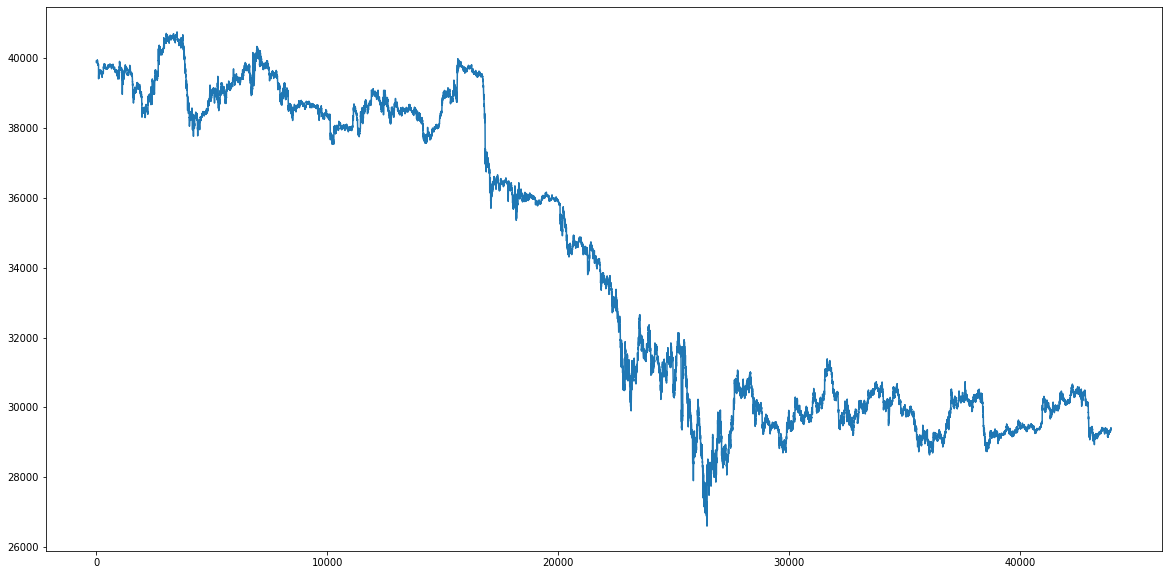

In [561]:
bitcoin_df['close'].plot(figsize=(20,10))

In [ ]:
# minmax scale it
bitcoin_df['returns'] = (bitcoin_df['returns']-bitcoin_df['returns'].min()) / (bitcoin_df['returns'].max()-bitcoin_df['returns'].min())
bitcoin_df['returns'].plot(figsize=(20,10))

In [ ]:
bull_lexicon = ['buy','call','forward','long','up','grow','rise','green','hold','carry','bull']
bear_lexicon = ['short','sell','down','drop','decrease','red','bear']

In [ ]:
twitter_df['bull_count'] = twitter_df['text'].apply(lambda x: any(substring in x for substring in bull_lexicon))
twitter_df['bear_count'] = twitter_df['text'].apply(lambda x: any(substring in x for substring in bear_lexicon))

In [ ]:
counts_per_day = twitter_df.reset_index().groupby('date')['index'].count()
counts_per_day.plot(figsize=(20,10))

In [ ]:
twitter_df['score'] = twitter_df['like_count'].astype(int)
twitter_df['score'] = twitter_df[['score']].apply(lambda x: x.fillna(x.mean()))
twitter_df['abs_score'] = np.abs(twitter_df['score'])

#Clustering
twitter_df = pd.merge(twitter_df.drop('abs_score', axis=1), 
                                 twitter_df.groupby('date')['abs_score'].sum(), left_on='date', right_index=True)

exp_scalar = 1.1
# Normalize score by total (absolute) score for that day
twitter_df['score_w'] = twitter_df['score']**exp_scalar /twitter_df['abs_score']
twitter_df = twitter_df.drop(['abs_score'], axis=1)
twitter_df['compound_sa'] = twitter_df['compound_sa'] * twitter_df['score_w']
twitter_df['neg_sa'] = twitter_df['neg_sa'] * twitter_df['score_w']
twitter_df['pos_sa'] = twitter_df['pos_sa'] * twitter_df['score_w']
twitter_df['neu_sa'] = twitter_df['neu_sa'] * twitter_df['score_w']
twitter_df['bull_count'] = twitter_df['bull_count'] * twitter_df['score_w']
twitter_df['bear_count'] = twitter_df['bear_count'] * twitter_df['score_w']

In [ ]:
twitter_df = twitter_df.groupby('date')[['score','compound_sa','neg_sa','pos_sa','neu_sa','bear_count','bull_count']].agg(
    {'compound_sa' : ['sum'], 
     'neg_sa' : ['sum'], 
     'neu_sa' : ['sum'], 
     'pos_sa' : ['sum'],
     'bear_count' : ['sum'],
     'bull_count' : ['sum'],
     'score' : ['mean']}).reset_index()

In [ ]:
twitter_df.plot(x = 'date', y = 'compound_sa', figsize=(20,10))
plt.show()

In [ ]:
twitter_df.plot(x = 'date', y = 'neg_sa', figsize=(20,10))
plt.show()

In [ ]:
twitter_df.plot(x = 'date', y = 'pos_sa', figsize=(20,10))
plt.show()

In [ ]:
twitter_df.plot(x = 'date', y = 'neu_sa', figsize=(20,10))
plt.show()

In [ ]:
twitter_df.plot(x = 'date', y = 'bear_count', figsize=(20,10))
plt.show()

In [ ]:
twitter_df.plot(x = 'date', y = 'bull_count', figsize=(20,10))
plt.show()

In [ ]:
twitter_df.plot(x = 'date', y = 'score', figsize=(20,10))
plt.show()
twitter_df = twitter_df.drop('score', axis=1)

In [ ]:
### Fast Fourier Transform on Sentiment Analyses

In [ ]:
from scipy.fftpack import fft, ifft

def fourier(df, n_dimensions, col):
    for n in n_dimensions:
        n = round(n)
        tmp_ = fft(df[col].values)
        tmp_[n:-n] = 0
        df[str(n)+'fourier'+col] = np.abs(ifft(tmp_))
    return df

# how to choose the values of fourier?
l = len(twitter_df)
twitter_df = fourier(twitter_df, [100, 200], 'compound_sa_sum')
twitter_df = fourier(twitter_df, [100, 200], 'pos_sa_sum')
twitter_df = fourier(twitter_df, [100, 200], 'neg_sa_sum')
twitter_df = fourier(twitter_df, [100, 200], 'neu_sa_sum')
returns = fourier(twitter_df['returns'], [200, 400], 'price')

In [ ]:
twitter_df[['compound_sa_sum','100fouriercompound_sa_sum','200fouriercompound_sa_sum']].plot(figsize=(20,10))

In [ ]:
twitter_df[['pos_sa_sum','100fourierpos_sa_sum','200fourierpos_sa_sum']].plot(figsize=(20,10))

In [ ]:
twitter_df[['neg_sa_sum','100fourierneg_sa_sum','200fourierneg_sa_sum']].plot(figsize=(20,10))

In [ ]:
twitter_df[['neu_sa_sum','100fourierneu_sa_sum','200fourierneu_sa_sum']].plot(figsize=(20,10))

In [ ]:
returns[['SPY_Open','200fourierSPY_Open','400fourierSPY_Open']].plot(figsize=(20,10))

In [ ]:
twitter_df = twitter_df.drop(['compound_sa_sum','pos_sa_sum','neg_sa_sum','neu_sa_sum'], axis=1)

In [ ]:
def merged_df(df, df_tickers):
    final_df = pd.merge(df, df_tickers, left_on='date_', right_on='Date')
    final_df = final_df.set_index('date_')
    return final_df

final_df = merged_df(twitter_df, returns)
#final_df.to_pickle(INTERM_DIR+f'/clean/Final_df_pkl')

In [ ]:
final_df.head()

In [ ]:
from numpy.lib.stride_tricks import sliding_window_view
y = bitcoin_df['prices']
# change between today and tomorrow is today's predictor
y = y.pct_change()[1:].apply(lambda x: 0 if x < 0 else 1).shift(-1)
y = y[y.index.isin(final_df.index)]
# the information throughout today is only known tomorrow ???
# investment decision is made before the open ??
X = final_df.shift(1).dropna().to_numpy()
window_size = 6
## No need to normalize, normalization happens due to feature engineering and bitcoin returns already normalized
# Create windows
# flip and flip back to make it a reverse window (t-2, t-3... t-window_size)
windowed_X = sliding_window_view(np.flip(X, axis=0), window_shape = window_size, axis=0)
windowed_X = np.flip(windowed_X, axis=0)
windowed_X = np.flip(windowed_X, axis=2)

y = y.iloc[window_size:].to_numpy()
print(windowed_X.shape)

### Splitting

In [ ]:
import sklearn
# print(sklearn.__version__) # make sure > 0.24

X = windowed_X

trainsplit = sklearn.model_selection.TimeSeriesSplit(n_splits=2, gap = window_size, test_size = int(0.3 * X.shape[0]))

for train_index, rem_index in trainsplit.split(X):

    X_train, X_rem = X[train_index], X[rem_index]
    y_train, y_rem = y[train_index], y[rem_index]
    

valsplit = sklearn.model_selection.TimeSeriesSplit(n_splits=2, gap = window_size, test_size = int(0.33 * X_rem.shape[0]))
for val_index, test_index in valsplit.split(X_rem):

    X_val, X_test = X_rem[val_index], X_rem[test_index]
    y_val, y_test = y_rem[val_index], y_rem[test_index]
    
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

In [ ]:
import pickle as pkl
with open(os.path.join(INTERM_DIR, 'train_data.pkl'), 'wb') as f:
    pkl.dump([X_train, y_train, X_val, y_val, X_test, y_test], f)

In [ ]:
with open(os.path.join(INTERM_DIR, 'train_data.pkl'), 'rb') as f:
    X_train, y_train, X_val, y_val, X_test, y_test = pkl.load(f)